# Predicting Home Credit Default Risk

-------------------------------------

<font size=3.5 ><text><strong>Ce projet a pour vocation d'identifier le risque de défaut de crédit des demandes soumises à la société <font color='blue'>Home Credit</font>.
</strong></text></font>

<br>
Les données étudiées sont disponible gratuitement sur le site Kaggle à cette adresse : https://www.kaggle.com/c/home-credit-default-risk/data
<br><br>
La vocation de la société <font color='blue'>"Home Credit"</font> est de donner accès à une population dépourvue d'historique de crédits et dans une situation bacaire précaire.
<br>
Pour cela la société financière a mis à disposition des données clients afin de permettre à chacun de proposer un modèle de décision capable de prêter crédit à des personnes injustement déclassées dans ce cadre de demande.
<br>
<br>
<img src="./img/schema-donnees-Home-Credit.JPG" alt="Présentation des données Home Credit">
<br>
<br>

Parmi les données disponible on notera dans le fichier <b>application_train.csv</b> :<br>
<ul>
<li> SK_ID\_CURR : Identifiant unique du demandeur</li>
<li> AMT_\* : les montants du support du crédit demandé pour AMT_CREDIT, de la somme à emprunter AMT_GOODS_PRICE, des mensualités à rembourser : AMT_ANNUITY </li>
<li> FLAG\* : une données binaire indicant si un document a été fourni ou non</li>
<li> DAYS\* : des périodes telles que l'Age, l'ancienneté de l'emploi actuel</li>
<li> EXT_[1,2,3] : Il y a 3 notes produites par des instituts financiers externes </li>
<li> \*[MEDI|AVG|MODE] : des données statistiques sur certains critères du support de l'emprunt</li>
</ul>
<br>
<br>

Les fichiers <b>bureau.csv</b> et <b>previous_application.csv</b> quant à eux serviront à générer des données aggrégées par SK_ID_CURR pour étoffer les variables disponible à l'analyse de la demande. Nous pourront notamment construire une vision des encours du demandeur.
<br>
<br>

<font size=3.5><strong>La structure de notre étude est la suivante : </strong></font>
<br><br>
<ul>
<li>I   – <a href="#chapI">Import des librairies et des données</a></li>
<li>II  - <a href="#chapII">Exploration des données "Application"</a></li>
<li>III – <a href="#chapIII">Sélection de variables et calcul de nouvelles variables</a></li> 
<li>IV  - <a href="#chapIV">Fichiers Crédits cloturés et en cours chez Home Credit</a></li>
<li>V   - <a href="#chapV">Données de Crédits contractés auprès d'instituts financiers tiers</a> </li>
<li>VI  - <a href="#chapVI">Fusion des différentes sources de données</a></li>
</ul>
<br>
<br>

## <p id="chapI">I - Import des librairies et des données</p>

--------------------------

--------------------------

<font size=3.5><strong>Chargement des librairies de manipulation de ces données</strong></font>

--------------------

In [1]:
import pandas as pd
import numpy as np

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 130
pd.options.display.max_rows = 130

<font size=3.5><strong>Chargement des données</strong></font>

--------------------

In [4]:
# Read files
## current application, previous application and application reported from Bureau
app_df = pd.read_csv("./data/application_train.csv")
prev_app_df  = pd.read_csv("./data/previous_application.csv")
bureau_df = pd.read_csv("./data/bureau.csv")


In [3]:
print(app_df.shape)
print(prev_app_df.shape)
print(bureau_df.shape)


(307511, 122)
(1670214, 37)
(1716428, 17)


In [5]:
app_columns = ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
               'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',  
               'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE',
              'TARGET']


# Taux de défaut de refus crédit 
sum(app_df.loc[:, "TARGET"])/app_df.shape[0]


0.080728819456864956

8% des individus ont eu un défaut de paiement.<br>
Nous faisons donc face à un jeu de données non balancé.<br>
Un ré-échantillonage du jeu de test aura donc lieu ultérieurement dans notre étude afin d'équilibrer notre dataset et donner un sens à la précision de nos modèles.

## <p id="chapII">II - Exploration des données "Application"</p>

--------------------------

--------------------------

<font size=3.5><strong>Chargement des librairies de manipulation de ces données</strong></font>

--------------------

(307511, 122)


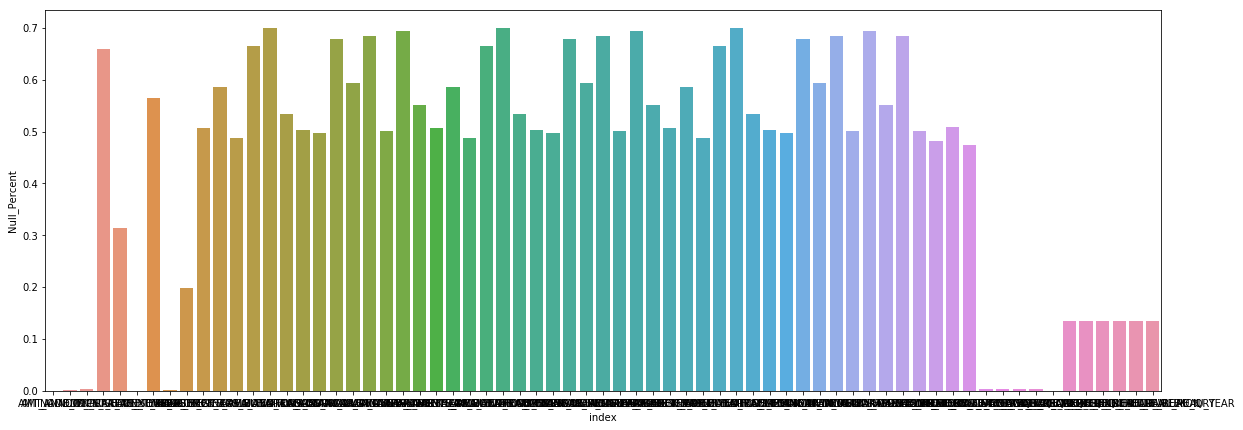

In [6]:
# Dimensions du fichier des demandes de crédit "Application"
print(app_df.shape)

# Observation des valeurs nulles dans le fichiers lu
app_nulls_df = pd.DataFrame(app_df.isnull().sum()/app_df.shape[0], columns = ['Null_Percent'])
app_nulls_df.reset_index(level=0, inplace=True)
#app_nulls.columns = ['Features','Null_Percent']
#app_nulls_df.head()
plt.figure(figsize=(20,7))
sns.barplot(x="index", y="Null_Percent",data=app_nulls_df[app_nulls_df.Null_Percent > 0])

Insérer ici un commentaire sur les données manquantes 

## <p id="chapIII">III - Sélection de variables et calcul de nouvelles variables</p>

--------------------------

--------------------------

<font size=3.5><strong>Sélection de variables</strong></font>

--------------------

Les attributs suivants semblent pertinents et ne présentent que peu de valeurs manquantes.
Dans ce qui suit, on complétera les attributs suivants avec d'autres attributs calculés.

In [7]:
# Sélection de variables
app_train_df = app_df[['SK_ID_CURR','TARGET','NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',
                       'CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','REGION_POPULATION_RELATIVE',
                       'DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OCCUPATION_TYPE',
                       'CNT_FAM_MEMBERS','ORGANIZATION_TYPE','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                       'OBS_30_CNT_SOCIAL_CIRCLE',
                       'DEF_30_CNT_SOCIAL_CIRCLE',
                       'OBS_60_CNT_SOCIAL_CIRCLE',
                       'DEF_60_CNT_SOCIAL_CIRCLE', 'YEARS_BUILD_AVG', 'DAYS_LAST_PHONE_CHANGE']]



<font size=3.5><strong>Calcul de nouvelles variables</strong></font>

--------------------

In [8]:
# Génération de variables
app_train_df["TOTAL_CONTACTS"] = app_df[["FLAG_MOBIL" ,"FLAG_EMP_PHONE"  ,"FLAG_WORK_PHONE"  ,"FLAG_CONT_MOBILE"  ,"FLAG_PHONE"    ,"FLAG_EMAIL"]].apply(lambda x : sum(x), 1)
app_train_df["TOTAL_DOCUMENTS"] = app_df[["FLAG_DOCUMENT_2","FLAG_DOCUMENT_3","FLAG_DOCUMENT_4","FLAG_DOCUMENT_5",
                                         "FLAG_DOCUMENT_6","FLAG_DOCUMENT_7","FLAG_DOCUMENT_8","FLAG_DOCUMENT_9",
                                         "FLAG_DOCUMENT_10","FLAG_DOCUMENT_11","FLAG_DOCUMENT_12","FLAG_DOCUMENT_13",
                                         "FLAG_DOCUMENT_14","FLAG_DOCUMENT_15","FLAG_DOCUMENT_16","FLAG_DOCUMENT_17",
                                         "FLAG_DOCUMENT_18","FLAG_DOCUMENT_19","FLAG_DOCUMENT_20",
                                         "FLAG_DOCUMENT_21"]].apply(lambda x : sum(x), 1)

# Calcul des ratio de défaut des personnes du cercle social du demandeur
app_train_df["DEF_30_RATIO"] = app_train_df['DEF_30_CNT_SOCIAL_CIRCLE'] / app_train_df["OBS_30_CNT_SOCIAL_CIRCLE"]
app_train_df["DEF_60_RATIO"] = app_train_df['DEF_60_CNT_SOCIAL_CIRCLE'] / app_train_df["OBS_60_CNT_SOCIAL_CIRCLE"]


# Calcul du prix du bien rapporté à la taille moyenne des habitations du quartier d'achat s'il s'agit d'un crédit immobilier 
def set_area_unit_price(train_row):
    price_meter = 0
    # Nous calculons le prix du mètre carré selon LIVINGAREA_AVG, s'il sagit d'une maison et LIVINGAPARTMENTS_AVG pour les appartements
    if not np.isnan(train_row.LIVINGAREA_AVG):
        price_meter = train_row["AMT_GOODS_PRICE"]/train_row["LIVINGAREA_AVG"]
    elif not np.isnan(train_row.LIVINGAPARTMENTS_AVG):
        price_meter = train_row["AMT_GOODS_PRICE"]/train_row["LIVINGAPARTMENTS_AVG"]
    return price_meter

app_train_df["METER_PRICE_AVG"] = app_df[["LIVINGAREA_AVG", "LIVINGAPARTMENTS_AVG", "AMT_GOODS_PRICE"]].apply(set_area_unit_price,1)

app_train_df = app_train_df.set_index('SK_ID_CURR')

In [9]:
print(app_train_df.shape)
app_train_df.isnull().sum()
print(app_train_df.info())

(307511, 36)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 36 columns):
TARGET                        307511 non-null int64
NAME_CONTRACT_TYPE            307511 non-null object
CODE_GENDER                   307511 non-null object
FLAG_OWN_CAR                  307511 non-null object
FLAG_OWN_REALTY               307511 non-null object
CNT_CHILDREN                  307511 non-null int64
AMT_INCOME_TOTAL              307511 non-null float64
AMT_CREDIT                    307511 non-null float64
AMT_ANNUITY                   307499 non-null float64
AMT_GOODS_PRICE               307233 non-null float64
NAME_INCOME_TYPE              307511 non-null object
NAME_EDUCATION_TYPE           307511 non-null object
NAME_FAMILY_STATUS            307511 non-null object
NAME_HOUSING_TYPE             307511 non-null object
REGION_POPULATION_RELATIVE    307511 non-null float64
DAYS_BIRTH                    307511 non-null int64
DAYS_EMPLOYED        

In [10]:
app_train_df_num = app_train_df.select_dtypes(include = ('float', 'int64'))

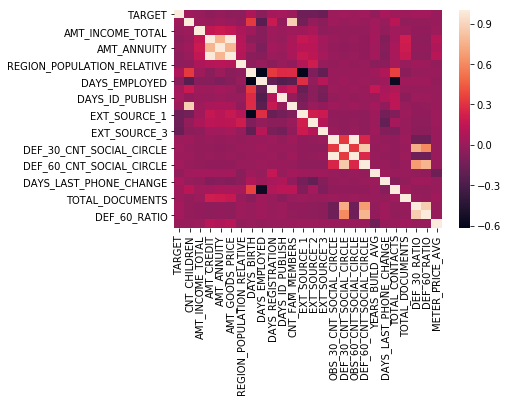

In [33]:
sns.heatmap(app_train_df_num.corr())

## <p id="chapIV">IV - Fichiers Crédits cloturés et en cours chez Home Credit</p>

--------------------------

--------------------------

<font size=3.5><strong>Calcul de variables à partir des demandes précédentes de crédit chez "Home Credit"</strong></font>

--------------------

In [11]:
# Première exploration des données, dimension et quantité de valeurs manquantes
print(prev_app_df.shape)
prev_app_df.isnull().sum()

(1670214, 37)


SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

<font size=3.5><strong>Calcul de nouvelles variables</strong></font>

--------------------

In [12]:
# On aggrège les données des contrats précédents
prev_app_count = prev_app_df.groupby('SK_ID_CURR').agg({'SK_ID_PREV':'count' })#, 'NAME_CONTRACT_TYPE' : 'count' , 
prev_app_count.columns = ['PREV_APP_CNT']

# On définit ici les montant des "encours" du client
prev_app_active_agg = prev_app_df[prev_app_df.DAYS_TERMINATION<0].groupby('SK_ID_CURR').agg({'AMT_ANNUITY' : 'sum', 'AMT_APPLICATION' : 'sum' , 
                                                          'AMT_CREDIT':'sum' , 'AMT_DOWN_PAYMENT' : 'sum',
                                                          'AMT_GOODS_PRICE' : 'sum' })

prev_app_active_agg.head()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE
SK_ID_CURR,,,,,
100001,3951.000,24835.5,23787.0,2520.0,24835.5
100002,9251.775,179055.0,179055.0,0.0,179055.0
100003,169661.970,1306309.5,1452573.0,6885.0,1306309.5
100004,5357.250,24282.0,20106.0,4860.0,24282.0
100005,4813.200,44617.5,40153.5,4464.0,44617.5


In [13]:
prev_app_active_agg.columns = [#'CNT_PREV_CONTRAT','CNT_PREV_CONTRAT_TYPE',
                            'PREV_APP_AMT_SUM_ANNUITY', 'PREV_APP_AMT_SUM_APP', 'PREV_APP_AMT_SUM_CREDIT',
                            'PREV_APP_AMT_SUM_DOWN_PAYMENT','PREV_APP_AMT_SUM_GOODS_PRICE']

In [14]:
prev_app_App = prev_app_df[prev_app_df.NAME_CONTRACT_STATUS == 'Approved'].groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].value_counts().unstack()
prev_app_Canceled = prev_app_df[prev_app_df.NAME_CONTRACT_STATUS == 'Canceled'].groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].value_counts().unstack()
prev_app_Refused = prev_app_df[prev_app_df.NAME_CONTRACT_STATUS == 'Refused'].groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].value_counts().unstack()
prev_app_Unused = prev_app_df[prev_app_df.NAME_CONTRACT_STATUS == 'Unused offer'].groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].value_counts().unstack()

In [15]:
# On renomme les variables pour plus de lisibilité
prev_app_App.columns = ['PREV_APP_CNT_CONTRACT_APPROVED']
prev_app_Canceled.columns = ['PREV_APP_CNT_CONTRACT_CANCELED']
prev_app_Refused.columns = ['PREV_APP_CNT_CONTRACT_REFUSED']
prev_app_Unused.columns = ['PREV_APP_CNT_CONTRACT_UNUSED']

<font size=3.5><strong>Fusion des données historique de "Home Credit"</strong></font>

--------------------

In [16]:
def merge_df_left(df_list):
    c_df = df_list[0]
    for df in df_list[1:]:
        c_df = pd.merge(c_df, df, left_index=True, right_index=True, how='left')
        
    return c_df
    
prev_app_merge_df = merge_df_left([prev_app_count, prev_app_active_agg, prev_app_App, prev_app_Canceled, prev_app_Refused, prev_app_Unused])    
prev_app_merge_df.head()

,PREV_APP_CNT,PREV_APP_AMT_SUM_ANNUITY,PREV_APP_AMT_SUM_APP,PREV_APP_AMT_SUM_CREDIT,PREV_APP_AMT_SUM_DOWN_PAYMENT,PREV_APP_AMT_SUM_GOODS_PRICE,PREV_APP_CNT_CONTRACT_APPROVED,PREV_APP_CNT_CONTRACT_CANCELED,PREV_APP_CNT_CONTRACT_REFUSED,PREV_APP_CNT_CONTRACT_UNUSED
SK_ID_CURR,,,,,,,,,,
100001,1,3951.000,24835.5,23787.0,2520.0,24835.5,1.0,NaN,NaN,NaN
100002,1,9251.775,179055.0,179055.0,0.0,179055.0,1.0,NaN,NaN,NaN
100003,3,169661.970,1306309.5,1452573.0,6885.0,1306309.5,3.0,NaN,NaN,NaN
100004,1,5357.250,24282.0,20106.0,4860.0,24282.0,1.0,NaN,NaN,NaN
100005,2,4813.200,44617.5,40153.5,4464.0,44617.5,1.0,1.0,NaN,NaN


## <p id="chapV">V - Données de Crédits contractés auprès d'instituts financiers tiers</p>

--------------------------

--------------------------

<font size=3.5><strong>Exploration des variables du "Bureau des crédits" </strong></font>

--------------------

Le fichier bureau représente une synthèse des crédits des clients dans d'autres banques.
<br>Il serait intéressant de rajouter ces données pour mieux appréhender la situation financière du demandeur.

In [17]:
bureau_df.shape
bureau_df.isnull().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

Nous allons récupérer les données <b>actives</b> provenant du "Bureau" afin de définir la situation des encours contractés dans des établissements financiés externes à "Home Credit".<br><br><br>
<font size=3.5><strong>Créations de variables </strong></font>

--------------------

In [41]:
bureau_df.CREDIT_ACTIVE.unique()

array(['Closed', 'Active', 'Sold', 'Bad debt'], dtype=object)

In [18]:
bureau_active_agg = bureau_df[bureau_df.CREDIT_ACTIVE=='Active'].groupby('SK_ID_CURR').agg({'SK_ID_BUREAU':'count' , # 'CREDIT_TYPE' : 'count' , 
                                                 'AMT_CREDIT_SUM' : 'sum' , 'AMT_CREDIT_SUM_LIMIT' : 'sum' , 
                                                 'AMT_CREDIT_SUM_DEBT' : 'sum',  'AMT_CREDIT_SUM_OVERDUE' : 'sum' , 
                                                 'CREDIT_DAY_OVERDUE' : 'max', 'AMT_ANNUITY':'sum' })
bureau_active_agg.head()

,SK_ID_BUREAU,AMT_CREDIT_SUM,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,CREDIT_DAY_OVERDUE,AMT_ANNUITY
SK_ID_CURR,,,,,,,
100001,3,884025.000,0.000,596686.5,0.0,0,24817.5
100002,2,481988.565,31988.565,245781.0,0.0,0,0.0
100003,1,810000.000,810000.000,0.0,0.0,0,NaN
100005,2,598626.000,0.000,568408.5,0.0,0,4261.5
100008,1,267606.000,0.000,240057.0,0.0,0,NaN


In [19]:
bureau_active_agg.columns = [ 'BUR_COUNT_CREDIT', 'BUR_AMT_CREDIT_SUM_TOT', 'BUR_AMT_CREDIT_SUM_LIMIT_TOT', 
                         'BUR_AMT_CREDIT_SUM_DEBT_TOT', 'BUR_AMT_CREDIT_SUM_OVERDU_TOT', 'BUR_CREDIT_DAY_OVERDU_MAX', 
                         'BUR_AMT_ANNUITY_TOT']
bureau_active_agg.head()

,BUR_COUNT_CREDIT,BUR_AMT_CREDIT_SUM_TOT,BUR_AMT_CREDIT_SUM_LIMIT_TOT,BUR_AMT_CREDIT_SUM_DEBT_TOT,BUR_AMT_CREDIT_SUM_OVERDU_TOT,BUR_CREDIT_DAY_OVERDU_MAX,BUR_AMT_ANNUITY_TOT
SK_ID_CURR,,,,,,,
100001,3,884025.000,0.000,596686.5,0.0,0,24817.5
100002,2,481988.565,31988.565,245781.0,0.0,0,0.0
100003,1,810000.000,810000.000,0.0,0.0,0,NaN
100005,2,598626.000,0.000,568408.5,0.0,0,4261.5
100008,1,267606.000,0.000,240057.0,0.0,0,NaN


In [20]:
#Enumération des crédit par statut
BUR_CRED_ACTIVE = bureau_df[bureau_df.CREDIT_ACTIVE == 'Active'].groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts().unstack()
BUR_CRED_CLOSED = bureau_df[bureau_df.CREDIT_ACTIVE == 'Closed'].groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts().unstack()
BUR_CRED_SOLD = bureau_df[bureau_df.CREDIT_ACTIVE == 'Sold'].groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts().unstack()
BUR_CRED_BAD = bureau_df[bureau_df.CREDIT_ACTIVE == 'Bad debt'].groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts().unstack()


# Somme totale des prolongations de crédits
BUR_CNT_PROLONG = pd.DataFrame(bureau_df.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].sum())

In [21]:
# Désignation finale des nouvelles variables provenant du Bureau des crédits
BUR_CRED_ACTIVE.columns = ['BUR_CNT_ACTIVE']
BUR_CRED_CLOSED.columns = ['BUR_CNT_CLOSED']
BUR_CRED_SOLD.columns = ['BUR_CNT_SOLD']
BUR_CRED_BAD.columns = ['BUR_CNT_BAD']

BUR_CNT_PROLONG.columns = ['BUR_CNT_CRED_PROLONG']

<font size=3.5><strong>Fusion des nouvelles variables externes </strong></font>

--------------------

In [22]:
bureau_merge_df = merge_df_left([bureau_active_agg, BUR_CRED_ACTIVE, BUR_CRED_CLOSED, BUR_CRED_SOLD, 
                                 BUR_CRED_BAD, BUR_CNT_PROLONG])
bureau_merge_df.head()


,BUR_COUNT_CREDIT,BUR_AMT_CREDIT_SUM_TOT,BUR_AMT_CREDIT_SUM_LIMIT_TOT,BUR_AMT_CREDIT_SUM_DEBT_TOT,BUR_AMT_CREDIT_SUM_OVERDU_TOT,BUR_CREDIT_DAY_OVERDU_MAX,BUR_AMT_ANNUITY_TOT,BUR_CNT_ACTIVE,BUR_CNT_CLOSED,BUR_CNT_SOLD,BUR_CNT_BAD,BUR_CNT_CRED_PROLONG
SK_ID_CURR,,,,,,,,,,,,
100001,3,884025.000,0.000,596686.5,0.0,0,24817.5,3,4.0,NaN,NaN,0
100002,2,481988.565,31988.565,245781.0,0.0,0,0.0,2,6.0,NaN,NaN,0
100003,1,810000.000,810000.000,0.0,0.0,0,NaN,1,3.0,NaN,NaN,0
100005,2,598626.000,0.000,568408.5,0.0,0,4261.5,2,1.0,NaN,NaN,0
100008,1,267606.000,0.000,240057.0,0.0,0,NaN,1,2.0,NaN,NaN,0


## <p id="chapVI">VI - Fusion des différentes source de données</p>

--------------------------

--------------------------

<font size=3.5><strong>Rapprochement des données, demandes en cours, passées et crédit en cours (externes) </strong></font>

--------------------

In [23]:
credit_risq =  merge_df_left([app_train_df_num, prev_app_merge_df, bureau_merge_df])

In [48]:
credit_risq.head(5).T

SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
CNT_CHILDREN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
AMT_INCOME_TOTAL,2.025000e+05,2.700000e+05,67500.000000,135000.000000,121500.000000
AMT_CREDIT,4.065975e+05,1.293502e+06,135000.000000,312682.500000,513000.000000
AMT_ANNUITY,2.470050e+04,3.569850e+04,6750.000000,29686.500000,21865.500000
AMT_GOODS_PRICE,3.510000e+05,1.129500e+06,135000.000000,297000.000000,513000.000000
REGION_POPULATION_RELATIVE,1.880100e-02,3.541000e-03,0.010032,0.008019,0.028663
DAYS_BIRTH,-9.461000e+03,-1.676500e+04,-19046.000000,-19005.000000,-19932.000000
DAYS_EMPLOYED,-6.370000e+02,-1.188000e+03,-225.000000,-3039.000000,-3038.000000
DAYS_REGISTRATION,-3.648000e+03,-1.186000e+03,-4260.000000,-9833.000000,-4311.000000



<font size=3.5><strong>Sauvegarde des données collectées</strong></font>

--------------------

In [24]:
credit_risq.to_csv("./data/credit_risq.csv")